## Implementing Decision Tree From Scratch

In [1]:
import uuid

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from graphviz import Digraph
from itertools import combinations
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

## Decision Tree With Entropy Implementation

In [2]:
class EntropyTreeNode:
    def __init__(self, type, feature, criterion, branches, value):
        self.id = uuid.uuid4().hex
        self.type = type
        self.feature = feature
        self.criterion = criterion
        self.branches = branches
        self.value = value
    
    def next(self, value):
        if self.type == "CATEGORICAL":
            return self.branches[value]
        
        if self.type == "CONTINUOUS":
            return self.branches["<="] if value <= self.value else self.branches[">"]
    
    @classmethod
    def categorical(cls, feature, criterion, branches):
        return cls("CATEGORICAL", feature, criterion, branches, None)
    
    @classmethod
    def continuous(cls, feature, criterion, value, left, right):
        branches = { "<=" : left, ">"  : right }
        return cls("CONTINUOUS", feature, criterion, branches, value)
    
    @classmethod
    def leaf(cls, value):
        return cls("LEAF", None, None, None, value)

In [3]:
class DecisionTreeClassifierEntropy:
    def __init__(self, max_depth=2, min_samples=2):
        self.max_depth = max_depth
        self.min_samples = min_samples
        self.root = None
        self.features = None
        self.graph = None
    
    def fit(self, data, target):
        self.features = np.array(data.drop(columns=[target]).columns, dtype=object)
        self.root = self.__build_tree(data, target, depth=0)
    
    def predict(self, data):
        result = []
        for i in data.index:
            result.append(DecisionTreeClassifierEntropy.__traverse(data.loc[i], self.root))
        return np.array(result)
    
    def visualize(self, size="5,5"):
        self.graph = Digraph()
        self.graph.attr(size=size)
        self.__generate_graph(self.root)
        return self.graph
    
    def __generate_graph(self, node):
        if node.type == "LEAF":
            self.graph.node(node.id, node.value, shape="oval", style="filled", color="#FF6868", fillcolor="#FF686880")
        else:
            self.graph.node(node.id, node.feature, shape="rectangle", style="filled", color="#A4CE95", fillcolor="#A4CE9580")
    
            for branch in node.branches:
                childNodeId = self.__generate_graph(node.branches[branch])
                
                if node.type == "CATEGORICAL":
                    self.graph.edge(node.id, childNodeId, label=f"{node.feature} == {branch}")
                    
                if node.type == "CONTINUOUS" :
                    self.graph.edge(node.id, childNodeId, label=f"{node.feature} {branch} {node.value}")

        return node.id
    
    def __build_tree(self, data, target, depth):     
        features = np.array(data.drop(columns=[target]).columns, dtype=object)
        
        if len(features) == 0 or len(np.unique(data[target].values)) == 1 or depth >= self.max_depth or data.shape[0] <= self.min_samples:
            return EntropyTreeNode.leaf(data[target].value_counts().idxmax())
            
        best_feature = {
            "name"      : None,
            "criterion" : None,
            "splits"    : None
        }
        
        for feature in features:
            if data[feature].dtype == "object":
                criterion, splits = DecisionTreeClassifierEntropy.__handle_categorical_feature(data, feature, target)
            else:
                criterion, splits = DecisionTreeClassifierEntropy.__handle_continuous_feature(data, feature, target)
            
            if best_feature["criterion"] == None or best_feature["criterion"] <= criterion:
                best_feature["name"] = feature
                best_feature["criterion"] = criterion
                best_feature["splits"] = splits
        
        if data[best_feature["name"]].dtype == "object":
            branches = { 
                category : self.__build_tree(
                    data[data[best_feature["name"]] == category].drop(columns=[best_feature["name"]]), 
                    target,
                    depth=depth + 1
                ) for category in best_feature["splits"] 
            }
            
            return EntropyTreeNode.categorical(best_feature["name"], best_feature["criterion"], branches)
        else:
            left  = self.__build_tree(
                data[data[best_feature["name"]] <= best_feature["splits"]].drop(columns=[best_feature["name"]]), 
                target, 
                depth=depth + 1
            )
            right = self.__build_tree(
                data[data[best_feature["name"]]  > best_feature["splits"]].drop(columns=[best_feature["name"]]), 
                target, 
                depth=depth + 1
            )
            
            return EntropyTreeNode.continuous(best_feature["name"], best_feature["criterion"], best_feature["splits"], left, right)
        
    @staticmethod
    def __entropy(x):
        _, counts = np.unique(x, return_counts=True)
        proportions = counts / np.sum(counts)
        
        return -np.sum(np.dot(proportions, np.log(proportions)))
        
    @staticmethod
    def __handle_categorical_feature(data, feature, target):
        entropy = DecisionTreeClassifierEntropy.__entropy(data[target].values)
        categories, categories_count = np.unique(data[feature].values, return_counts=True)
        categories_proportion = categories_count / np.sum(categories_count)
        delta = np.dot(
            categories_proportion, 
            np.array(
                [DecisionTreeClassifierEntropy.__entropy(data[data[feature] == category][target].values) for category in categories], 
                dtype=np.float64
            )
        )
        gain = entropy - delta
        
        return gain, categories
    
    @staticmethod
    def __handle_continuous_feature(data, feature, target):
        entropy = DecisionTreeClassifierEntropy.__entropy(data[target].values)
        sorted_data = data.sort_values(by=feature, ascending=True).reset_index(drop=True)
        best_split = {
            "gain"  : None,
            "value" : None
        }
        
        checked = set() # Way to prevent unncessary recomputation of already computed split points
        
        for i in range(1, sorted_data.shape[0]):
            value = (sorted_data.loc[i - 1, feature] + sorted_data.loc[i, feature]) / 2
            
            if value not in checked:
                sorted_data["mask"] = sorted_data[feature] <= value 
                masks, masks_count = np.unique(sorted_data["mask"].values, return_counts=True)
                masks_proportion = masks_count / np.sum(masks_count)
                delta = np.dot(
                    masks_proportion, 
                    np.array(
                        [DecisionTreeClassifierEntropy.__entropy(sorted_data[sorted_data["mask"] == mask][target].values) for mask in masks], 
                        dtype=np.float64
                    )
                )
                gain = entropy - delta
                
                if best_split["gain"] == None or best_split["gain"] <= gain:
                    best_split["gain"] = gain
                    best_split["value"] = value
                
                checked.add(value)
        
        return best_split["gain"], best_split["value"]
    
    @staticmethod
    def __traverse(data, node):
        if node.type != "LEAF":
            return DecisionTreeClassifierEntropy.__traverse(data, node.next(data[node.feature]))
        else:
            return node.value

## Decision Tree With Gini Implementation

In [4]:
class GiniTreeNode:
    def __init__(self, type, feature, gini, split, left, right, value):
        self.id = uuid.uuid4().hex
        self.type = type
        self.feature = feature
        self.gini = gini
        self.split = split
        self.left = left
        self.right = right
        self.value = value
    
    def next(self, value):
        if self.type == "CATEGORICAL":
            return self.left if value in self.split else self.right
        
        if self.type == "CONTINUOUS":
            return self.left if value <= self.split else self.right
        
        if self.type == "LEAF":
            return self.value
        
        return None
    
    @classmethod
    def categorical(cls, feature, gini, split, left, right):
        return cls("CATEGORICAL", feature, gini, split, left, right, None)
    
    @classmethod
    def continuous(cls, feature, gini, split, left, right):
        return cls("CONTINUOUS", feature, gini, split, left, right, None)
    
    @classmethod
    def leaf(cls, gini, value):
        return cls("LEAF", None, gini, None, None, None, value)

In [5]:
class DecisionTreeClassifierGini:
    def __init__(self, max_depth=2, min_samples=2):
        self.max_depth = max_depth
        self.min_samples = min_samples
        self.root = None
        self.features = None
        self.graph = None
    
    def fit(self, data, target):
        self.features = np.array(data.drop(columns=[target]).columns, dtype=object)
        self.root = self.__build_tree(data, target, depth=0)
    
    def predict(self, data):
        return np.array([DecisionTreeClassifierGini.__traverse(data.loc[i], self.root) for i in data.index])
    
    def visualize(self, direction="TB", size="8.0, 10.0"):
        self.graph = Digraph(name="Tree", graph_attr={"rankdir": direction, "size": size})
        self.__generate_graph(self.root)
        return self.graph
    
    def __generate_graph(self, node):
        if node.type == "LEAF":
            label=f"target={node.value}\ngini={node.gini}"
            self.graph.node(node.id, label, shape="oval", style="filled", color="#FF6868", fillcolor="#FF686880")
        else:
            label=f"{node.feature}\nsplit={node.split}\ngini={node.gini}"
            self.graph.node(node.id, label, shape="rectangle", style="filled", color="#A4CE95", fillcolor="#A4CE9580")
            self.graph.edge(node.id, self.__generate_graph(node.left))
            self.graph.edge(node.id, self.__generate_graph(node.right))

        return node.id
    
    def __build_tree(self, data, target, depth):     
        if len(np.unique(data[target].values)) == 1 or depth >= self.max_depth or data.shape[0] <= self.min_samples:
            gini = DecisionTreeClassifierGini.__gini(data[target].values)
            return GiniTreeNode.leaf(gini, data[target].value_counts().idxmax())
        
        features = np.array(data.drop(columns=[target]).columns, dtype=object)
        best = { "name" : None, "gini" : float("inf"), "value" : None }
        
        for feature in features:
            gini, value = DecisionTreeClassifierGini.__find_best_split(data, feature, target)
            
            if gini < best["gini"]:
                best = { "name" : feature, "gini" : gini, "value" : value }
        
        if data[best["name"]].dtype == "object":
            mask = data[best["name"]].isin(best["value"])
            left = self.__build_tree(data[mask], target, depth + 1)
            right = self.__build_tree(data[~mask], target, depth + 1)
            
            return GiniTreeNode.categorical(best["name"], best["gini"], best["value"], left, right)
        else:
            mask = data[best["name"]] <= best["value"]
            left = self.__build_tree(data[mask], target, depth + 1)
            right = self.__build_tree(data[~mask], target, depth + 1)
            
            return GiniTreeNode.continuous(best["name"], best["gini"], best["value"], left, right)
        
    @staticmethod
    def __gini(x):
        _, counts = np.unique(x, return_counts=True)
        proportions = np.divide(counts, np.sum(counts))
        return 1 - np.sum(np.square(proportions))
    
    @staticmethod
    def __find_best_split(data, feature, target):
        values = []
        splits = []
        best_split = None
        best_gini = float("inf")

        if data[feature].dtype == "object":
            # Initilizing the possible values for split when the feature is categorical
            values = set(data[feature].values)
            
            for i in range(1, len(values)):
                for combination in combinations(values, i):
                    split = set(combination)
                    difference = values - split
                    
                    if difference not in splits:
                        splits.append(split)
        else:
            # Initilizing the possible values for split when the feature is continuous
            values = np.sort(data[feature].values)
            
            for i in range(1, values.size):
                split = (values[i - 1] + values[i]) / 2
                
                if split not in splits:
                    splits.append(split)
        
        # Finding the best split (Split with least gini)
        for split in splits:
            mask = None
            
            if data[feature].dtype == "object":
                mask = data[feature].isin(split)
            else:
                mask = data[feature] <= split
            
            count = np.array([data[mask].shape[0], data[~mask].shape[0]], dtype=np.int64)
            proportion = np.divide(count, np.sum(count))
            gini = np.dot(
                proportion,
                np.array(
                    [
                        DecisionTreeClassifierGini.__gini(data[mask][target].values),
                        DecisionTreeClassifierGini.__gini(data[~mask][target].values)
                    ], 
                    dtype=np.float64
                )
            )

            if gini < best_gini:
                best_gini = gini
                best_split = split
        
        return best_gini, best_split
    
    @staticmethod
    def __traverse(data, node):
        if node.type != "LEAF":
            return DecisionTreeClassifierGini.__traverse(data, node.next(data[node.feature]))
        else:
            return node.value

## Training The Decision Tree With Entropy For Drug Dataset

In [ ]:
data_drug = pd.read_csv("https://raw.githubusercontent.com/Guhan-B/The-Machine-Learning-Repository/refs/heads/main/datasets/drug_a_b_c_x_y.csv")

In [7]:
data_drug.head(10)

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY
5,22,F,NORMAL,HIGH,8.607,drugX
6,49,F,NORMAL,HIGH,16.275,drugY
7,41,M,LOW,HIGH,11.037,drugC
8,60,M,NORMAL,HIGH,15.171,drugY
9,43,M,LOW,NORMAL,19.368,drugY


In [8]:
# using object type for categorical columns
# Using int64 & float64 for contineous columns
column_to_type_mapping_for_drug_data = {
    "Age"         : np.int64,
    "Na_to_K"     : np.float64,
    "Sex"         : object,
    "BP"          : object,
    "Cholesterol" : object,
    "Drug"        : object
}

data_drug = data_drug.astype(column_to_type_mapping_for_drug_data)

In [9]:
features_drug = ["Age", "Na_to_K", "Sex", "BP", "Cholesterol"]
target_drug = "Drug"

X_drug = data_drug[features_drug]
y_drug = data_drug[target_drug]

In [10]:
X_train_drug, X_test_drug, y_train_drug, y_test_drug = train_test_split(X_drug, y_drug, test_size=0.2, shuffle=True, stratify=y_drug)

train_data_drug = X_train_drug.copy()
train_data_drug[target_drug] = y_train_drug
train_data_drug.reset_index(inplace=True, drop=True)

test_data_drug = X_test_drug.copy()
test_data_drug[target_drug] = y_test_drug
test_data_drug.reset_index(inplace=True, drop=True)

print("Training data size:", train_data_drug.shape)
print("Testing data size:", test_data_drug.shape)

Training data size: (160, 6)
Testing data size: (40, 6)


In [11]:
train_data_drug.head(10)

,Age,Na_to_K,Sex,BP,Cholesterol,Drug
0,46,34.686,F,HIGH,HIGH,drugY
1,65,13.769,F,LOW,NORMAL,drugX
2,16,19.007,M,HIGH,NORMAL,drugY
3,63,25.917,M,NORMAL,HIGH,drugY
4,20,9.281,F,NORMAL,NORMAL,drugX
5,19,13.313,F,HIGH,HIGH,drugA
6,69,15.478,M,LOW,HIGH,drugY
7,61,9.443,M,NORMAL,HIGH,drugX
8,50,12.295,F,NORMAL,NORMAL,drugX
9,47,10.403,M,HIGH,HIGH,drugA


In [12]:
test_data_drug.head(10)

,Age,Na_to_K,Sex,BP,Cholesterol,Drug
0,37,13.091,F,HIGH,HIGH,drugA
1,59,13.935,M,HIGH,HIGH,drugB
2,32,9.445,M,HIGH,NORMAL,drugA
3,68,27.050,F,NORMAL,NORMAL,drugY
4,32,7.477,F,NORMAL,HIGH,drugX
5,65,11.340,M,HIGH,NORMAL,drugB
6,65,34.997,M,HIGH,NORMAL,drugY
7,24,18.457,F,HIGH,NORMAL,drugY
8,64,20.932,M,HIGH,NORMAL,drugY
9,52,9.894,M,NORMAL,HIGH,drugX


In [13]:
model_drug = DecisionTreeClassifierEntropy(max_depth=10)

In [14]:
model_drug.fit(data=train_data_drug, target=target_drug)

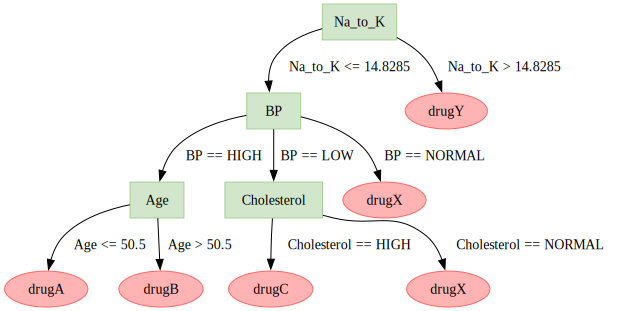

In [15]:
model_drug.visualize(size="10.0, 10.0")

In [16]:
drug_train_target = train_data_drug[target_drug].values
drug_train_target_predicted = model_drug.predict(train_data_drug)

drug_test_target = test_data_drug[target_drug].values
drug_test_target_predicted = model_drug.predict(test_data_drug)

In [17]:
drug_train_accuracy = accuracy_score(drug_train_target, drug_train_target_predicted)
drug_test_accuracy = accuracy_score(drug_test_target, drug_test_target_predicted)

print(f"Accuracy on Training Data: {round(drug_train_accuracy * 100, 2)}%")
print(f"Accuracy on Test Data: {round(drug_test_accuracy * 100, 2)}%")

Accuracy on Training Data: 100.0%
Accuracy on Test Data: 100.0%


## Training The Decision Tree With Gini Index For Loan Dataset

In [ ]:
data_loan = pd.read_csv("https://raw.githubusercontent.com/Guhan-B/The-Machine-Learning-Repository/refs/heads/main/datasets/loan_eligibility_train.csv")

In [19]:
data_loan.head(10)

,Unnamed: 0,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,0,LP001518,Male,Yes,1,Graduate,No,1538,1425.0,30.0,360.0,1.0,Urban,Y
1,1,LP002734,Male,Yes,0,Graduate,No,6133,3906.0,324.0,360.0,1.0,Urban,Y
2,2,LP002697,Male,No,0,Graduate,No,4680,2087.0,NaN,360.0,1.0,Semiurban,N
3,3,LP002455,Male,Yes,2,Graduate,No,3859,0.0,96.0,360.0,1.0,Semiurban,Y
4,4,LP001732,Male,Yes,2,Graduate,NaN,5000,0.0,72.0,360.0,0.0,Semiurban,N
5,5,LP001841,Male,No,0,Not Graduate,Yes,2583,2167.0,104.0,360.0,1.0,Rural,Y
6,6,LP002348,Male,Yes,0,Graduate,No,5829,0.0,138.0,360.0,1.0,Rural,Y
7,7,LP002194,Female,No,0,Graduate,Yes,15759,0.0,55.0,360.0,1.0,Semiurban,Y
8,8,LP001641,Male,Yes,1,Graduate,Yes,2178,0.0,66.0,300.0,0.0,Rural,N
9,9,LP001931,Female,No,0,Graduate,No,4124,0.0,115.0,360.0,1.0,Semiurban,Y


In [20]:
data_loan = data_loan.dropna()

In [21]:
# using object type for categorical columns
# Using int64 & float64 for contineous columns
column_to_type_mapping_for_loan_data = {
    "Gender"            : object,
    "Married"           : object,
    "Dependents"        : object,
    "Education"         : object,
    "Self_Employed"     : object,
    "ApplicantIncome"   : np.float64,
    "CoapplicantIncome" : np.float64,
    "LoanAmount"        : np.float64,
    "Loan_Amount_Term"  : np.float64,
    "Credit_History"    : object,
    "Property_Area"     : object
    
}

data_loan = data_loan.astype(column_to_type_mapping_for_loan_data)

In [22]:
features_loan = [
    "Gender", 
    "Married", 
    "Dependents", 
    "Education", 
    "Self_Employed", 
    "ApplicantIncome", 
    "CoapplicantIncome", 
    "LoanAmount",
    "Loan_Amount_Term",
    "Credit_History",
    "Property_Area"
]
target_loan = "Loan_Status"

X_loan = data_loan[features_loan]
y_loan = data_loan[target_loan]

In [23]:
X_train_loan, X_test_loan, y_train_loan, y_test_loan = train_test_split(X_loan, y_loan, test_size=0.1, shuffle=True, stratify=y_loan)

train_data_loan = X_train_loan.copy()
train_data_loan[target_loan] = y_train_loan
train_data_loan.reset_index(inplace=True, drop=True)

test_data_loan = X_test_loan.copy()
test_data_loan[target_loan] = y_test_loan
test_data_loan.reset_index(inplace=True, drop=True)

print("Training data size:", train_data_loan.shape)
print("Testing data size:", test_data_loan.shape)

Training data size: (335, 12)
Testing data size: (38, 12)


In [24]:
train_data_loan.head(10)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Not Graduate,No,2755.0,0.0,65.0,300.0,1.0,Rural,N
1,Male,No,0,Not Graduate,No,4885.0,0.0,48.0,360.0,1.0,Rural,Y
2,Male,Yes,0,Not Graduate,No,2583.0,2358.0,120.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2253.0,2033.0,110.0,360.0,1.0,Rural,Y
4,Male,Yes,0,Graduate,No,3887.0,2669.0,162.0,360.0,1.0,Semiurban,Y
5,Male,No,2,Graduate,No,3588.0,0.0,110.0,360.0,0.0,Rural,N
6,Male,Yes,1,Graduate,No,5649.0,0.0,44.0,360.0,1.0,Urban,Y
7,Male,Yes,0,Graduate,No,3166.0,2064.0,104.0,360.0,0.0,Urban,N
8,Male,Yes,3+,Not Graduate,No,2947.0,1664.0,70.0,180.0,0.0,Urban,N
9,Male,Yes,0,Graduate,No,3941.0,2336.0,134.0,360.0,1.0,Semiurban,Y


In [25]:
test_data_loan.head(10)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,4683.0,1915.0,185.0,360.0,1.0,Semiurban,N
1,Female,Yes,0,Graduate,No,3167.0,2283.0,154.0,360.0,1.0,Semiurban,Y
2,Male,No,0,Graduate,No,5815.0,3666.0,311.0,360.0,1.0,Rural,N
3,Male,No,2,Graduate,No,3547.0,0.0,80.0,360.0,0.0,Rural,N
4,Male,Yes,0,Graduate,No,5708.0,5625.0,187.0,360.0,1.0,Semiurban,Y
5,Male,Yes,3+,Graduate,No,3029.0,0.0,99.0,360.0,1.0,Urban,Y
6,Male,No,0,Graduate,No,1926.0,1851.0,50.0,360.0,1.0,Semiurban,Y
7,Male,No,0,Graduate,No,5941.0,4232.0,296.0,360.0,1.0,Semiurban,Y
8,Male,Yes,0,Graduate,No,9323.0,0.0,75.0,180.0,1.0,Urban,Y
9,Male,Yes,1,Graduate,No,5955.0,5625.0,315.0,360.0,1.0,Urban,Y


In [26]:
model_loan = DecisionTreeClassifierGini(max_depth=5)

In [27]:
model_loan.fit(train_data_loan, target_loan)

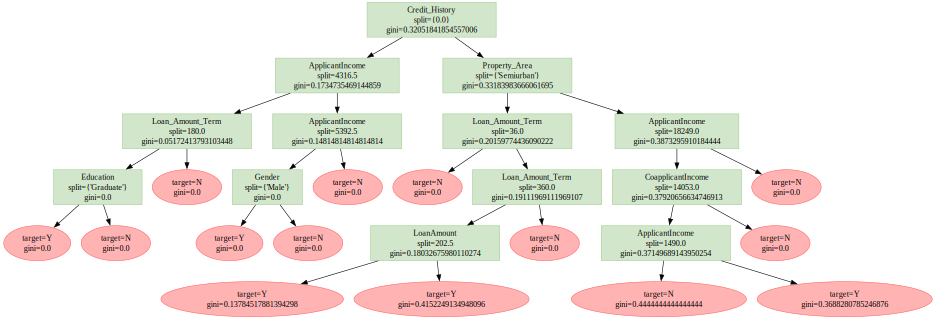

In [28]:
model_loan.visualize(size="13, 13")

In [29]:
loan_train_target = train_data_loan[target_loan].values
loan_train_target_predicted = model_loan.predict(train_data_loan)

loan_test_target = test_data_loan[target_loan].values
loan_test_target_predicted = model_loan.predict(test_data_loan)

In [30]:
loan_train_accuracy = accuracy_score(loan_train_target, loan_train_target_predicted)
loan_test_accuracy = accuracy_score(loan_test_target, loan_test_target_predicted)

print(f"Accuracy on Training Data: {round(loan_train_accuracy * 100, 2)}%")
print(f"Accuracy on Test Data: {round(loan_test_accuracy * 100, 2)}%")

Accuracy on Training Data: 83.88%
Accuracy on Test Data: 78.95%
